In [1]:
# Set the Environment
# Ignore Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
#Write out the versions of all packages to requirements.txt
!pip freeze >> requirements.txt
#!pip unfreeze requirements.txt

# Remove the restriction on Jupyter that limits the columns displayed (the ... in the middle)
pd.set_option('display.max_columns',None)
# Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html#

# Pretty Display of variables.  for instance, you can call df.head() and df.tail() in the same cell and BOTH display w/o print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# List of ALL Magic Commands.  To run a magic command %var  --- i.e.:  %env
%lsmagic
# %env  -- list environment variables
# %%time  -- gives you information about how long a cel took to run
# %%timeit -- runs a cell 100,000 times and then gives you the average time the cell will take to run (can be LONG)
# %pdb -- python debugger

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

print(np.__version__)
print(sklearn.__version__)

1.26.0
1.3.0


In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%matplotlib inline

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/main/tsa_claims1.csv", low_memory=False)

In [4]:
df.head()

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approved,350.00,Approve in Full
1,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settled,227.92,Settle
2,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved,50.00,Approve in Full
3,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved,84.79,Approve in Full
4,2005032479636,18-Feb-02,2/17/2005 0:00,CAK,Akron-Canton Regional,Air Tran Airlines(do not use),Passenger Property Loss,Checked Baggage,Other,459.01,Settled,227.00,Settle


# Insurance Claim Data Analysis

## Questions and Corresponding Columns

1. **What is the most common type of insurance claim?**
   - *Relevant Column:* `Claim Type`

2. **Which claim site within the airport are claims most commonly filed for?**
   - *Relevant Columns:* `Claim Site`

3. **What type of claim is made most at each claim site?**
   - *Relevant Columns:* `Claim Site`, `Claim Type`

4. **What is the typical claim amount?**
   - *Relevant Column:* `Claim Amount`

5. **What is the overall claim approval rate for the entire U.S.?**
   - *Relevant Column:* `Status`

## Columns to be Deleted and Rationale

- **Date Received**: Deleted because it does not contribute to the specific questions being asked about types of claims, locations, and amounts, unless the analysis requires time-based trends.

- **Incident Date**: Deleted for the same reason as 'Date Received'; it is not necessary for the current questions unless the analysis is time-bound.

- **Airline Name**: Deleted as it does not pertain to the nature of claims, their location within the airport, or the approval rate which are the focus of the questions.

- **Close Amount**: While this provides information on the settled claim amount, it is not essential for determining the typical claim amount or the approval rate based on the questions provided.

- **Disposition**: This column's detail on the outcome of the claims process is more granular than required for the current questions, which focus on the approval rate rather than the type of approval or settlement.

In [5]:
# List of columns to be deleted
columns_to_delete = ['Date Received', 'Incident Date', 'Airline Name', 'Close Amount', 'Disposition']

# Delete the columns from the DataFrame
df.drop(columns=columns_to_delete, inplace=True)

In [6]:
df.head()

,Claim Number,Airport Code,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Status
0,0909802M,EWR,Newark International Airport,Property Damage,Checkpoint,Other,350.00,Approved
1,0202445M,STL,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,Settled
2,0909816M,MIA,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved
3,2005032379513,MCO,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved
4,2005032479636,CAK,Akron-Canton Regional,Passenger Property Loss,Checked Baggage,Other,459.01,Settled


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94848 entries, 0 to 94847
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Claim Number  94848 non-null  object 
 1   Airport Code  94848 non-null  object 
 2   Airport Name  94848 non-null  object 
 3   Claim Type    94848 non-null  object 
 4   Claim Site    94848 non-null  object 
 5   Item          94848 non-null  object 
 6   Claim Amount  94848 non-null  float64
 7   Status        94848 non-null  object 
dtypes: float64(1), object(7)
memory usage: 5.8+ MB


## Checking for Unique Values

The insights gathered from the unique value check are as follows:

- **Claim Number**: This column has a unique value for each row, indicating it's a good candidate for setting as the DataFrame index.
- **Airport Code and Airport Name**: Both columns have the same number of unique values. This suggests redundancy between the two, so for simplicity and better readability, I will delete the `Airport Code` column.
- **Claim Type**: With only 6 unique values, this column is ideal for conversion to the `category` data type to optimize memory usage.
- **Claim Site**: Similarly, with only 4 unique values, this column will also be converted to `category`.
- **Status**: Having 5 unique values makes this column another candidate for conversion to `category`.


In [8]:
# To get the number of unique values for each column
unique_counts = {col: df[col].nunique() for col in df.columns if df[col].dtype == 'object'}

# Print out the number of unique values for each column
for col, count in unique_counts.items():
    print(f"{col} has {count} unique values")


Claim Number has 94848 unique values
Airport Code has 411 unique values
Airport Name has 411 unique values
Claim Type has 6 unique values
Claim Site has 4 unique values
Item has 3072 unique values
Status has 5 unique values


In [9]:
df['Claim Type'] = df['Claim Type'].astype('category')
df['Claim Site'] = df['Claim Site'].astype('category')
df['Status'] = df['Status'].astype('category')


In [10]:
# Set 'Claim Number' as the index of the DataFrame
df.set_index('Claim Number', inplace=True)

# Delete the 'Airport Code' column from the DataFrame
df.drop('Airport Code', axis=1, inplace=True)


In [11]:
df.head()

,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Status
Claim Number,,,,,,
0909802M,Newark International Airport,Property Damage,Checkpoint,Other,350.00,Approved
0202445M,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,Settled
0909816M,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved
2005032379513,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved
2005032479636,Akron-Canton Regional,Passenger Property Loss,Checked Baggage,Other,459.01,Settled


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94848 entries, 0909802M to 2009122866807
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Airport Name  94848 non-null  object  
 1   Claim Type    94848 non-null  category
 2   Claim Site    94848 non-null  category
 3   Item          94848 non-null  object  
 4   Claim Amount  94848 non-null  float64 
 5   Status        94848 non-null  category
dtypes: category(3), float64(1), object(2)
memory usage: 3.2+ MB


## Verify Correctness of Categories

In [13]:
# For each categorical column, print the unique values
categorical_columns = df.select_dtypes(include=['category']).columns

for col in categorical_columns:
    print(f"Unique values in '{col}':\n{df[col].cat.categories}\n")


Unique values in 'Claim Type':
Index(['Employee Loss (MPCECA)', 'Motor Vehicle', 'Passenger Property Loss',
       'Passenger Theft', 'Personal Injury', 'Property Damage'],
      dtype='object')

Unique values in 'Claim Site':
Index(['Checked Baggage', 'Checkpoint', 'Motor Vehicle', 'Other'], dtype='object')

Unique values in 'Status':
Index(['Approved', 'Canceled', 'Denied', 'Pending response from claimant',
       'Settled'],
      dtype='object')



In [14]:
df.describe()

,Claim Amount
count,9.484800e+04
mean,3.634831e+03
std,5.249437e+05
min,0.000000e+00
25%,6.500000e+01
50%,1.836900e+02
75%,4.806425e+02
max,1.250000e+08


In [15]:
# Calculate IQR
Q1 = df['Claim Amount'].quantile(0.25)
Q3 = df['Claim Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
outliers = df[(df['Claim Amount'] < lower_bound) | (df['Claim Amount'] > upper_bound)]

print(f"Outliers in 'Claim Amount':\n{outliers}")


Outliers in 'Claim Amount':
                                                   Airport Name  \
Claim Number                                                      
18966                             John F. Kennedy International   
18614                             Orlando International Airport   
19907                                       Tampa International   
18671                      Chicago O'Hare International Airport   
20106                           Cleveland Hopkins International   
...                                                         ...   
2010010467065                      Denver International Airport   
2010010567127                       Miami International Airport   
2010010567156                            McCarran International   
2010010767270  Hartsfield-Jackson Atlanta International Airport   
2009122866807                     John F. Kennedy International   

                            Claim Type       Claim Site  \
Claim Number                             

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Amount'>

Text(0.5, 1.0, 'Boxplot of Claim Amounts')

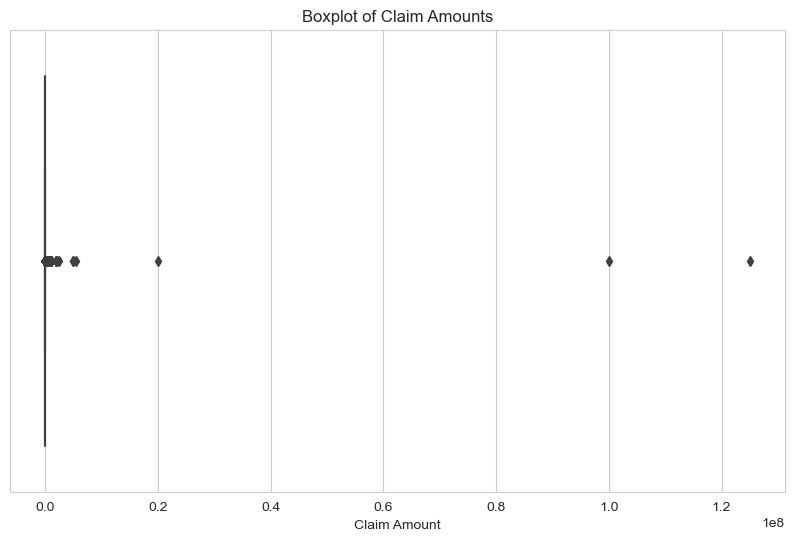

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Amount', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Claim Amounts')

Text(0.5, 0, 'Claim Amount')

Text(0, 0.5, 'Frequency')

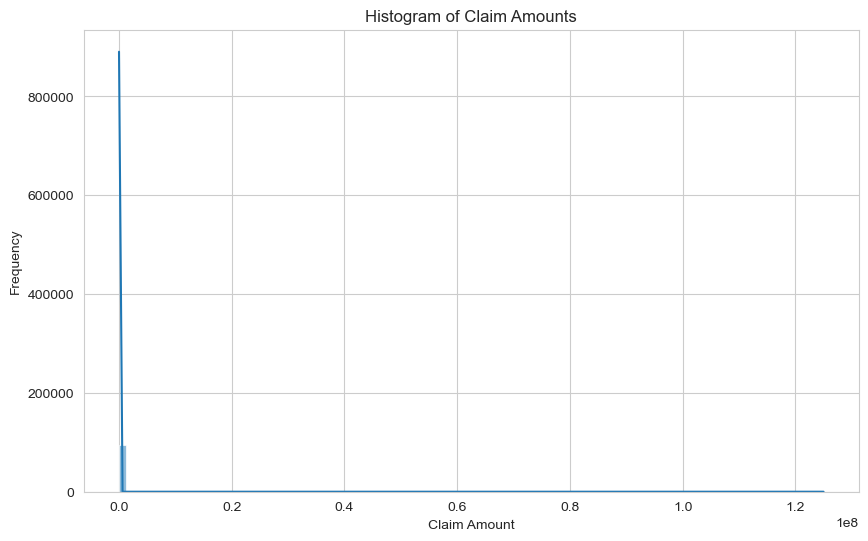

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Claim Amount'])
plt.title('Boxplot of Claim Amounts')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Claim Amount'], bins=100, kde=True)  # KDE plots the density estimation
plt.title('Histogram of Claim Amounts')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot example (assuming you want to plot Claim Amounts against another variable 'X')
# plt.figure(figsize=(10, 6))
# plt.scatter(df['X'], df['Claim Amount'])
# plt.title('Scatter Plot of Claim Amounts against X')
# plt.xlabel('X')
# plt.ylabel('Claim Amount')
# plt.show()


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Amount', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Claim Amounts (Limited Range)')

Text(0.5, 0, 'Claim Amount')

Text(0, 0.5, 'Frequency')

(0.0, 1104.10625)

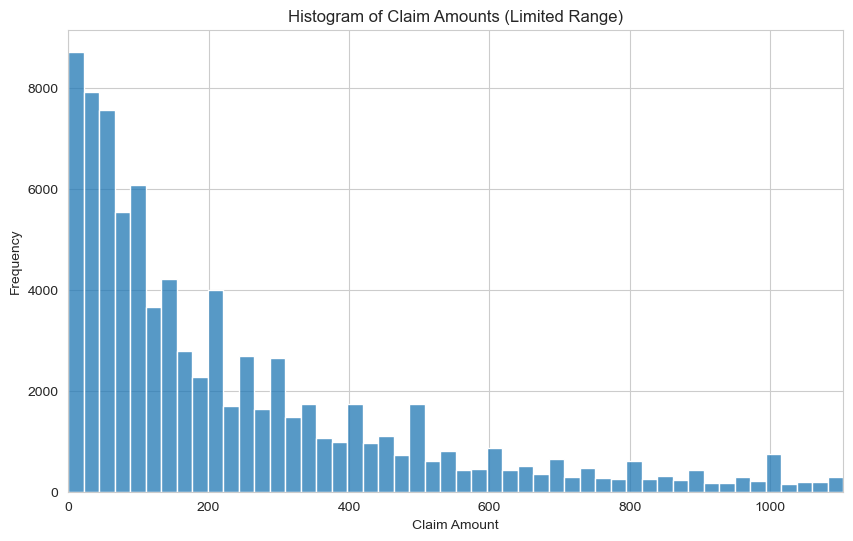

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Amount', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Claim Amounts (Log Scale)')

Text(0.5, 0, 'Claim Amount (log scale)')

Text(0, 0.5, 'Frequency')

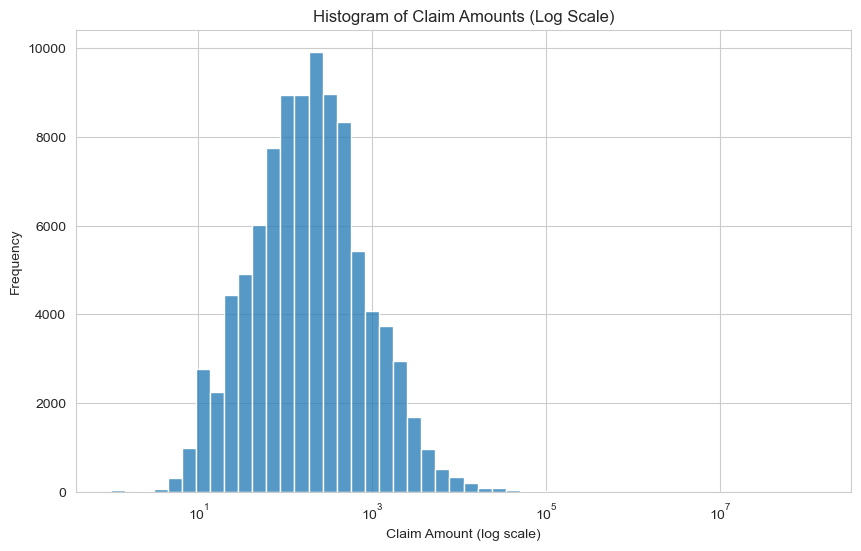

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a histogram with a limited x-axis
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Claim Amount'] <= upper_bound]['Claim Amount'], bins=50) # Adjust 'upper_bound' as needed
plt.title('Histogram of Claim Amounts (Limited Range)')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.xlim(0, upper_bound)  # Set the upper limit for x-axis
plt.show()

# Create a histogram with log transformation
plt.figure(figsize=(10, 6))
# Add a small constant to avoid log(0) issue
sns.histplot(df['Claim Amount'] + 1, bins=50, log_scale=True)
plt.title('Histogram of Claim Amounts (Log Scale)')
plt.xlabel('Claim Amount (log scale)')
plt.ylabel('Frequency')
plt.show()


In [18]:
df.describe()

,Claim Amount
count,9.484800e+04
mean,3.634831e+03
std,5.249437e+05
min,0.000000e+00
25%,6.500000e+01
50%,1.836900e+02
75%,4.806425e+02
max,1.250000e+08


In [19]:
def log_transform_claim_amount(df, column_name='Claim Amount'):
    """
    Apply a log transformation to the 'Claim Amount' column of the DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the 'Claim Amount' column.
    column_name (str): The name of the column to transform (default is 'Claim Amount').

    Returns:
    pandas.DataFrame: A new DataFrame with the log-transformed 'Claim Amount'.
    """

    # Copy the DataFrame to avoid changes to the original data
    transformed_df = df.copy()
    
    # Check if the column exists in the DataFrame
    if column_name in transformed_df.columns:
        # Add 1 to the column values to avoid log(0)
        transformed_df[column_name] = np.log1p(transformed_df[column_name])
    else:
        raise ValueError(f"The column '{column_name}' is not in the DataFrame.")
    
    return transformed_df

# Usage:
# Assuming 'df' is your original DataFrame
cleaned_df = log_transform_claim_amount(df)


In [20]:
cleaned_df.describe()

,Claim Amount
count,94848.000000
mean,5.213440
std,1.504599
min,0.000000
25%,4.189655
50%,5.218679
75%,6.177202
max,18.643824


In [21]:
cleaned_df.head()

,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Status
Claim Number,,,,,,
0909802M,Newark International Airport,Property Damage,Checkpoint,Other,5.860786,Approved
0202445M,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,5.634361,Settled
0909816M,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),3.931826,Approved
2005032379513,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,4.451902,Approved
2005032479636,Akron-Canton Regional,Passenger Property Loss,Checked Baggage,Other,6.131248,Settled


In [22]:
df.head()

,Airport Name,Claim Type,Claim Site,Item,Claim Amount,Status
Claim Number,,,,,,
0909802M,Newark International Airport,Property Damage,Checkpoint,Other,350.00,Approved
0202445M,Lambert St. Louis International,Property Damage,Checked Baggage,Cell Phones,278.88,Settled
0909816M,Miami International Airport,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approved
2005032379513,Orlando International Airport,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approved
2005032479636,Akron-Canton Regional,Passenger Property Loss,Checked Baggage,Other,459.01,Settled


# 1. What is the most common type of insurance claim?

In [23]:
# Assuming 'df' is your DataFrame and 'Claim Type' is the column of interest
most_common_claim_type = df['Claim Type'].value_counts().idxmax()

# Print the most common claim type
print(f"The most common type of insurance claim is: {most_common_claim_type}")


The most common type of insurance claim is: Passenger Property Loss


In [24]:
# Get the distribution of all claim types
claim_type_distribution = df['Claim Type'].value_counts()

# Print the distribution
print(claim_type_distribution)


Claim Type
Passenger Property Loss    60265
Property Damage            33730
Passenger Theft              331
Employee Loss (MPCECA)       308
Personal Injury              208
Motor Vehicle                  6
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Type'>

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Employee Loss (MPCECA)'),
  Text(1, 0, 'Motor Vehicle'),
  Text(2, 0, 'Passenger Property Loss'),
  Text(3, 0, 'Passenger Theft'),
  Text(4, 0, 'Personal Injury'),
  Text(5, 0, 'Property Damage')])

Text(0.5, 1.0, 'Frequency of Each Claim Type')

Text(0.5, 0, 'Claim Type')

Text(0, 0.5, 'Frequency')

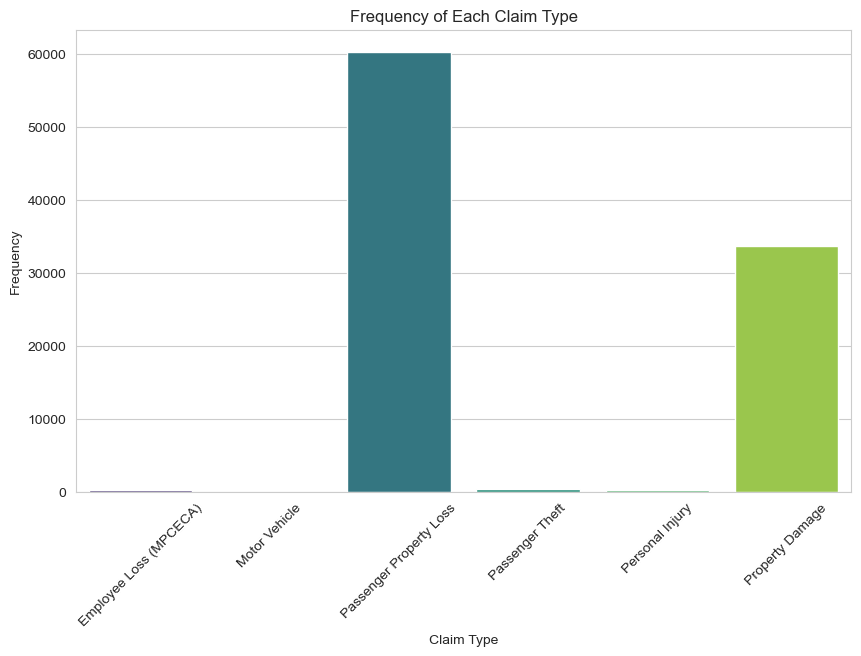

In [25]:
# Count the frequency of each claim type
claim_type_counts = df['Claim Type'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=claim_type_counts.index, y=claim_type_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title('Frequency of Each Claim Type')
plt.xlabel('Claim Type')
plt.ylabel('Frequency')
plt.show()


# 2. Which claim site within the airport are claims most commonly filed for?

In [26]:
# Get the count of claims for each claim site
claim_site_counts = df['Claim Site'].value_counts()

# Identify the most common claim site
most_common_claim_site = claim_site_counts.idxmax()

# Print the most common claim site
print(f"The most common claim site within the airport is: {most_common_claim_site}")
print()
# If you want to see the counts for all claim sites
print(claim_site_counts)


The most common claim site within the airport is: Checked Baggage

Claim Site
Checked Baggage    80553
Checkpoint         14013
Other                280
Motor Vehicle          2
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Claim Site'>

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Checked Baggage'),
  Text(1, 0, 'Checkpoint'),
  Text(2, 0, 'Motor Vehicle'),
  Text(3, 0, 'Other')])

Text(0.5, 1.0, 'Most Common Claim Sites Within the Airport')

Text(0.5, 0, 'Claim Site')

Text(0, 0.5, 'Number of Claims')

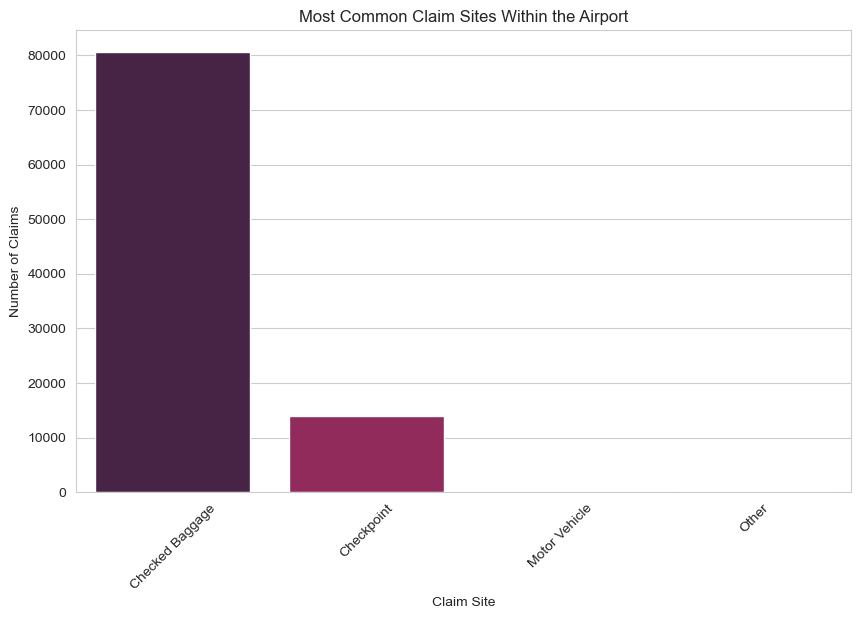

In [27]:
# Count the frequency of claims at each site
claim_site_counts = df['Claim Site'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=claim_site_counts.index, y=claim_site_counts.values, palette="rocket")
plt.xticks(rotation=45)
plt.title('Most Common Claim Sites Within the Airport')
plt.xlabel('Claim Site')
plt.ylabel('Number of Claims')
plt.show()


# 3. What type of claim is made most at each claim site?

In [28]:
df['Claim Site'].unique()

['Checkpoint', 'Checked Baggage', 'Other', 'Motor Vehicle']
Categories (4, object): ['Checked Baggage', 'Checkpoint', 'Motor Vehicle', 'Other']

In [29]:
# Group by 'Claim Site' and then get the most common 'Claim Type' within each group
most_common_types_by_site = df.groupby('Claim Site')['Claim Type'].agg(lambda x: x.value_counts().idxmax())

# Print the most common claim type at each claim site
print("The most common claim type at each claim site:")
print()
print(most_common_types_by_site)


The most common claim type at each claim site:

Claim Site
Checked Baggage    Passenger Property Loss
Checkpoint                 Property Damage
Motor Vehicle      Passenger Property Loss
Other              Passenger Property Loss
Name: Claim Type, dtype: object


<Axes: xlabel='Claim Site'>

Text(0.5, 1.0, 'Claim Type Distribution by Claim Site')

Text(0.5, 0, 'Claim Site')

Text(0, 0.5, 'Number of Claims')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Checked Baggage'),
  Text(1, 0, 'Checkpoint'),
  Text(2, 0, 'Motor Vehicle'),
  Text(3, 0, 'Other')])

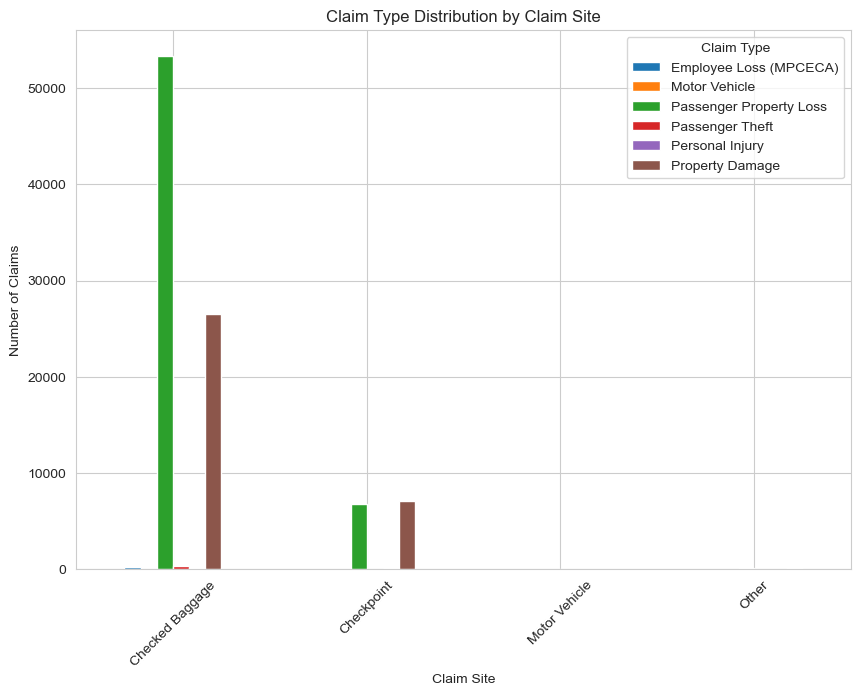

In [30]:
# Prepare data: count the occurrences of each claim type within each claim site
claim_data = df.groupby(['Claim Site', 'Claim Type']).size().unstack()

# Plotting
claim_data.plot(kind='bar', figsize=(10, 7))

# Adding title and labels
plt.title('Claim Type Distribution by Claim Site')
plt.xlabel('Claim Site')
plt.ylabel('Number of Claims')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.legend(title='Claim Type')
plt.show()

# 4. What is the typical claim amount?

I chose the median as the measure for the typical claim amount because it is the value that sits in the middle of the dataset when it is ordered. The median is often a better representation of what might be considered "typical," especially if the data contains outliers. Outliers can skew the mean, making it less representative of the central tendency of the data. Therefore, the median is generally more robust in the presence of extreme values.


In [31]:
# Calculate the median claim amount
median_claim_amount = df['Claim Amount'].median()

# Print the typical claim amounts
print(f"The median claim amount is: ${median_claim_amount:.2f}")


The median claim amount is: $183.69


<Figure size 1000x800 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x16ba7929750>,
 'caps': [<matplotlib.lines.Line2D at 0x16ba7148310>,
 'boxes': [<matplotlib.lines.Line2D at 0x16ba4965610>],
 'medians': [<matplotlib.lines.Line2D at 0x16ba7116a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x16ba7275210>],
 'means': []}

Text(0.5, 1.0, 'Box Plot of Claim Amount')

Text(0, 0.5, 'Claim Amount (log scale)')

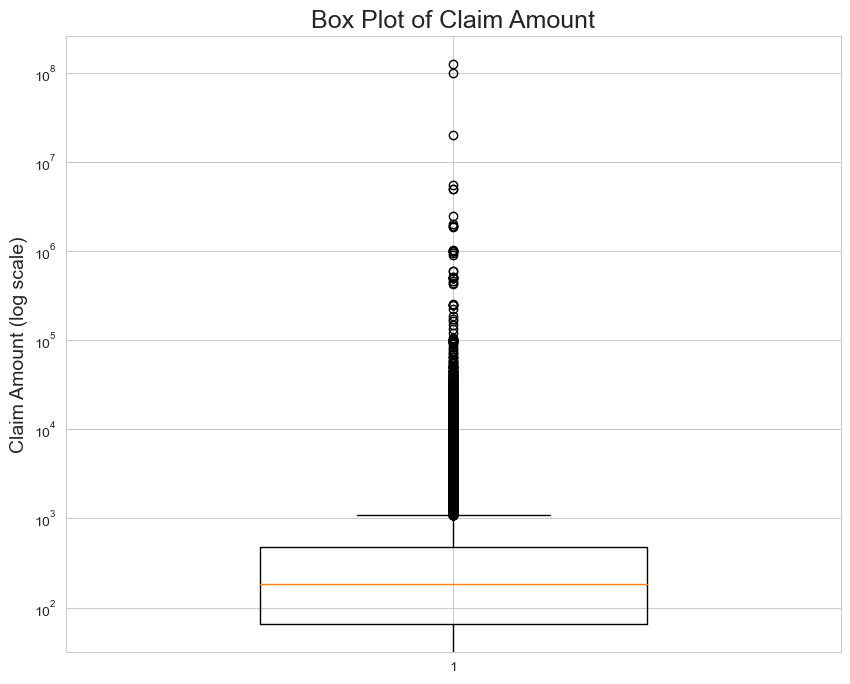

In [32]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create a box plot with a logarithmic scale
plt.boxplot(df['Claim Amount'], widths=0.5, showfliers=True)  # Set showfliers to False to hide outliers

# Set a logarithmic scale for the Y axis
plt.yscale('log')

# Add gridlines
plt.grid(True)

# Set labels and title with increased font sizes
plt.title('Box Plot of Claim Amount', fontsize=18)
plt.ylabel('Claim Amount (log scale)', fontsize=14)

# Show plot
plt.show()

# 5. What is the overall claim approval rate for the entire U.S.?

In [33]:
# Count the number of approved claims
# Here, we assume that the status 'Approved' indicates an approved claim
# Adjust the string 'Approved' if your data uses a different indicator for approval
approved_claims = df['Status'].value_counts().get('Approved', 0)

# Calculate the total number of claims
total_claims = len(df)

# Calculate the approval rate
approval_rate = (approved_claims / total_claims) * 100

# Print the overall claim approval rate
print(f"The overall claim approval rate for the entire U.S. is: {approval_rate:.2f}%")


The overall claim approval rate for the entire U.S. is: 24.43%


<Figure size 800x800 with 0 Axes>

([<matplotlib.patches.Wedge at 0x16ba4eae6d0>,
 [Text(-0.5316093568853512, -0.9630116778481679, 'Denied'),
  Text(0.9872733796508888, 0.485068318727076, 'Approved'),
  Text(-0.2856744808859272, 1.0622570738623285, 'Settled'),
  Text(-0.8424614859860564, 0.7072896469128938, 'Canceled'),
  Text(-0.8426254532185251, 0.7070942975221023, 'Pending response from claimant')],
 [Text(-0.2899687401192824, -0.5252790970080915, '56.2%'),
  Text(0.5385127525368484, 0.2645827193056778, '24.4%'),
  Text(-0.15582244411959664, 0.5794129493794518, '19.4%'),
  Text(-0.45952444690148525, 0.38579435286157837, '0.0%'),
  Text(-0.4596138835737409, 0.3856877986484194, '0.0%')])

Text(0.5, 1.0, 'Claim Approval Rate')

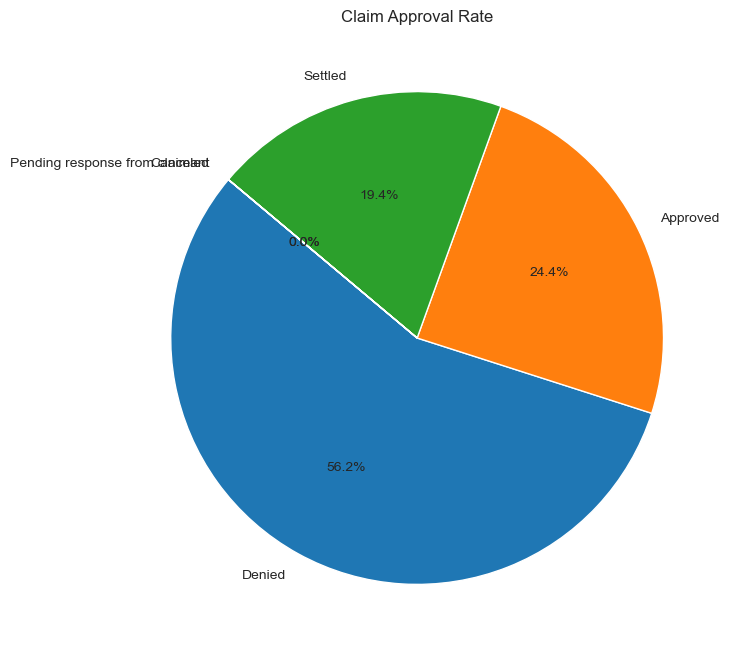

In [34]:
# Calculate the proportion of each status
status_counts = df['Status'].value_counts()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("tab10"))
plt.title('Claim Approval Rate')
plt.show()
